In [6]:
import sys
import os
sys.path.append(os.path.abspath("/content/drive/MyDrive/Colab Notebooks/session10"))
os.chdir("/content/drive/MyDrive/Colab Notebooks/session10")

In [7]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/session10'

In [8]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [10]:
from transforms import CustomResnetTransforms
from dataloader import Cifar10SearchDataset

In [13]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = CustomResnetTransforms.train_transforms(means, stds)
test_transforms = CustomResnetTransforms.test_transforms(means, stds)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [14]:
train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:01<00:00, 97259650.60it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [15]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [18]:
!pip install torchinfo

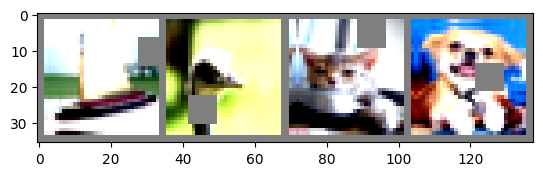

ship  bird  cat   dog  


In [20]:
import matplotlib.pyplot as plt
import numpy as np
from utils import imshow

# functions to show an image


# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [21]:
from model import MyResNet
from utils import print_summary, get_lr, get_device

In [27]:
# from torchinfo import summary

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# print(device)
# model = MyResNet().to(device)
# summary(model, input_size=(3, 32, 32))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = MyResNet().to(device)
summary(model, input_size=(512, 3, 32, 32))

cuda


Layer (type:depth-idx)                   Output Shape              Param #
MyResNet                                 [512, 10]                 --
├─Sequential: 1-1                        [512, 64, 32, 32]         --
│    └─Conv2d: 2-1                       [512, 64, 32, 32]         1,792
│    └─BatchNorm2d: 2-2                  [512, 64, 32, 32]         128
│    └─ReLU: 2-3                         [512, 64, 32, 32]         --
├─Sequential: 1-2                        [512, 128, 16, 16]        --
│    └─Conv2d: 2-4                       [512, 128, 32, 32]        73,856
│    └─MaxPool2d: 2-5                    [512, 128, 16, 16]        --
│    └─BatchNorm2d: 2-6                  [512, 128, 16, 16]        256
│    └─ReLU: 2-7                         [512, 128, 16, 16]        --
├─ResBlock: 1-3                          [512, 128, 16, 16]        --
│    └─Sequential: 2-8                   [512, 128, 16, 16]        --
│    │    └─Conv2d: 3-1                  [512, 128, 16, 16]        147,456
│

In [41]:
# device = get_device()
# print(device)
# model = MyResNet().to(device)
# print_summary(model, device, input_size=(512,3, 32, 32))

In [30]:
from train import train, test


In [31]:
!pip install torch-lr-finder

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.04E-02


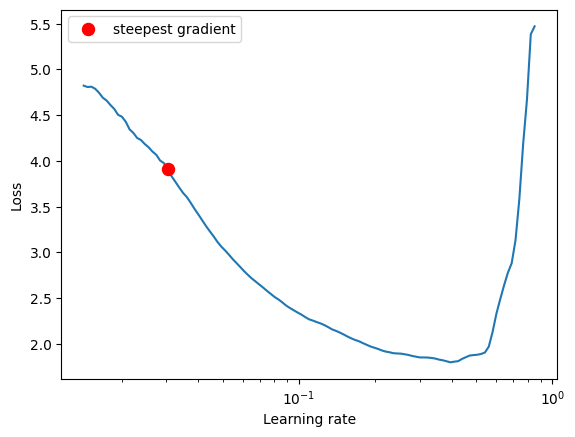

In [32]:
from torch_lr_finder import LRFinder

model = MyResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [34]:
from torch.optim.lr_scheduler import OneCycleLR

model =  MyResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
EPOCHS = 24
scheduler = OneCycleLR(
        optimizer,
        max_lr = 3.04E-02, #1.74E-02,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

criterion = nn.CrossEntropyLoss()
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')
    train_losses, train_acc = train(model, device, train_loader, optimizer, criterion, scheduler, train_losses, train_acc)
    test_losses, test_acc = test(model, device, test_loader, criterion, test_losses, test_acc)


Epoch 1


Train: Loss=0.8950 Batch_id=97 Accuracy=52.62: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]


Test set: Average loss: 0.0021, Accuracy: 6415/10000 (64.15%)

Epoch 2


Train: Loss=0.6971 Batch_id=97 Accuracy=69.72: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]


Test set: Average loss: 0.0018, Accuracy: 7106/10000 (71.06%)

Epoch 3


Train: Loss=0.7165 Batch_id=97 Accuracy=74.15: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]


Test set: Average loss: 0.0018, Accuracy: 7111/10000 (71.11%)

Epoch 4


Train: Loss=0.6582 Batch_id=97 Accuracy=76.34: 100%|██████████| 98/98 [00:33<00:00,  2.96it/s]


Test set: Average loss: 0.0014, Accuracy: 7711/10000 (77.11%)

Epoch 5


Train: Loss=0.5957 Batch_id=97 Accuracy=79.38: 100%|██████████| 98/98 [00:33<00:00,  2.90it/s]


Test set: Average loss: 0.0025, Accuracy: 6201/10000 (62.01%)

Epoch 6


Train: Loss=0.5190 Batch_id=97 Accuracy=79.59: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]


Test set: Average loss: 0.0012, Accuracy: 7993/10000 (79.93%)

Epoch 7


Train: Loss=0.5192 Batch_id=97 Accuracy=81.36: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]


Test set: Average loss: 0.0013, Accuracy: 7889/10000 (78.89%)

Epoch 8


Train: Loss=0.5810 Batch_id=97 Accuracy=82.21: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]


Test set: Average loss: 0.0014, Accuracy: 7801/10000 (78.01%)

Epoch 9


Train: Loss=0.4616 Batch_id=97 Accuracy=82.70: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]


Test set: Average loss: 0.0013, Accuracy: 7834/10000 (78.34%)

Epoch 10


Train: Loss=0.4753 Batch_id=97 Accuracy=83.09: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]


Test set: Average loss: 0.0011, Accuracy: 8067/10000 (80.67%)

Epoch 11


Train: Loss=0.3880 Batch_id=97 Accuracy=83.14: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]


Test set: Average loss: 0.0011, Accuracy: 8150/10000 (81.50%)

Epoch 12


Train: Loss=0.4948 Batch_id=97 Accuracy=84.08: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]


Test set: Average loss: 0.0013, Accuracy: 7716/10000 (77.16%)

Epoch 13


Train: Loss=0.4433 Batch_id=97 Accuracy=84.53: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]


Test set: Average loss: 0.0013, Accuracy: 7911/10000 (79.11%)

Epoch 14


Train: Loss=0.4882 Batch_id=97 Accuracy=84.87: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]


Test set: Average loss: 0.0010, Accuracy: 8271/10000 (82.71%)

Epoch 15


Train: Loss=0.5446 Batch_id=97 Accuracy=85.67: 100%|██████████| 98/98 [00:32<00:00,  2.97it/s]


Test set: Average loss: 0.0009, Accuracy: 8534/10000 (85.34%)

Epoch 16


Train: Loss=0.3616 Batch_id=97 Accuracy=86.26: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]


Test set: Average loss: 0.0010, Accuracy: 8363/10000 (83.63%)

Epoch 17


Train: Loss=0.3953 Batch_id=97 Accuracy=86.80: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]


Test set: Average loss: 0.0009, Accuracy: 8408/10000 (84.08%)

Epoch 18


Train: Loss=0.4628 Batch_id=97 Accuracy=87.55: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]


Test set: Average loss: 0.0008, Accuracy: 8659/10000 (86.59%)

Epoch 19


Train: Loss=0.3219 Batch_id=97 Accuracy=88.23: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]


Test set: Average loss: 0.0007, Accuracy: 8739/10000 (87.39%)

Epoch 20


Train: Loss=0.3242 Batch_id=97 Accuracy=89.61: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]


Test set: Average loss: 0.0007, Accuracy: 8737/10000 (87.37%)

Epoch 21


Train: Loss=0.3067 Batch_id=97 Accuracy=90.51: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]


Test set: Average loss: 0.0007, Accuracy: 8810/10000 (88.10%)

Epoch 22


Train: Loss=0.1778 Batch_id=97 Accuracy=92.21: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]


Test set: Average loss: 0.0006, Accuracy: 9010/10000 (90.10%)

Epoch 23


Train: Loss=0.1661 Batch_id=97 Accuracy=93.75: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]


Test set: Average loss: 0.0005, Accuracy: 9165/10000 (91.65%)

Epoch 24


Train: Loss=0.1682 Batch_id=97 Accuracy=95.24: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]


Test set: Average loss: 0.0005, Accuracy: 9253/10000 (92.53%)

